<a href="https://colab.research.google.com/github/ErfanRasti/MachineLearningProjects/blob/main/NaturalLanguageProcessing/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='green'>NLP Project</font>

<div class="alert alert-block alert-warning">
<b>
Amirkabir University of Technology<br>
Fall 2022<br>
Course: Machine Learning<br>
Instructor: Dr. Seyedin<br>
<b><font color='green'>Authors:</font></b><br>
Name: Amir Azad<br />
Student Number: 9823004</div>
Name: Erfan Rasti<br />
Student Number: 9823034</div>


***

# <font color='purple'>Importing Required Packages</font>

In [1]:
! pip install transformers
! pip install datasets
! pip install sentence-transformers
! pip install evaluate


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 15.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [2]:
# from transformers import AutoTokenizer
import pandas as pd
import torch
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn import metrics
from sentence_transformers import SentenceTransformer
from transformers import TrainingArguments, Trainer
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# <font color='purple'>Loading the dataset from Hugging Face</font>

In [4]:
from datasets import load_dataset
dataset = load_dataset('tweet_eval', 'hate')

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/9000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2970 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2970
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})


In [6]:
print(dataset['train'][0])
print(dataset['test'][2])

{'text': '@user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…', 'label': 0}
{'text': '@user @user Those People Invaded Us!!! They DO NOT BELING HERE & HAVE NO RIGHTS! Its #AmericaFIRST! Open Your House To Them If Your That IGNORANT! & Yes Im A #Christian Too! #NODACA!', 'label': 1}


# <font color='purple'>Preprocessing Data</font>


In [7]:
def preprocess_sentence(sentence):
    # remove punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    sentence = re.sub(r'\d+', '', sentence)
    # remove whitespace
    sentence = sentence.strip()
    # remove stopwords
    sentence = ' '.join([word for word in sentence.split()
                        if word not in stopwords.words('english')])
    return sentence


In [8]:
def preprocess_dataset(dataset):
    dataset = dataset.map(
        lambda examples: {'text': preprocess_sentence(examples['text'])})
    return dataset


In [9]:
dataset = preprocess_dataset(dataset)
print(dataset['train'][0])
print(dataset['test'][2])

  0%|          | 0/9000 [00:00<?, ?ex/s]

  0%|          | 0/2970 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

{'text': 'user nice new signage Are concerned Beatlemania style hysterical crowds crongregating you…', 'label': 0}
{'text': 'user user Those People Invaded Us They DO NOT BELING HERE HAVE NO RIGHTS Its AmericaFIRST Open Your House To Them If Your That IGNORANT Yes Im A Christian Too NODACA', 'label': 1}


In [10]:
#You can use bert-base or DistilBert as a model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

def tokenize_dataset(dataset):
    tokenized_dataset = dataset.map(lambda examples: tokenizer(examples['text'], truncation=True, padding='max_length'), batched=True)
    return tokenized_dataset

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [11]:
dataset = tokenize_dataset(dataset)
print(dataset['train'][0])
print(dataset['validation'][0])
print(dataset['test'][2])

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

{'text': 'user nice new signage Are concerned Beatlemania style hysterical crowds crongregating you…', 'label': 0, 'input_ids': [101, 4795, 3505, 1207, 2951, 2553, 2372, 4264, 11938, 14183, 11262, 1947, 177, 21878, 4571, 13484, 172, 16822, 1874, 18401, 1128, 795, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# <font color='purple'>Fine-tune a model</font>

You should complete this section

In [12]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased', num_labels=2)

training_args = TrainingArguments(output_dir="test_trainer",
                                  evaluation_strategy="epoch",
                                  learning_rate=1e-6,
                                  num_train_epochs=3,
                                  weight_decay=0.01,
                                  optim="adamw_torch")


Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weigh

In [13]:
import numpy as np
import evaluate


metrics_to_compute = evaluate.combine([
    evaluate.load("accuracy"),
    evaluate.load("precision"),
    evaluate.load("recall"),
    evaluate.load("f1"),
])


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metrics_to_compute.compute(predictions, labels)




In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_metrics,
)

trainer.train()

# <font color='purple'>Evaluation</font>

You should complete this section

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2970
  Batch size = 8


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.481900,0.514210,0.752000,0.682281,0.784543,0.729847
2,0.359500,0.598969,0.748000,0.663551,0.831382,0.738046


Accuracy:  0.5074074074074074
Precision:  0.45841545132045725
Recall:  0.9289137380191693
F1:  0.6138822908419109
ROC AUC:  0.5645732834449747


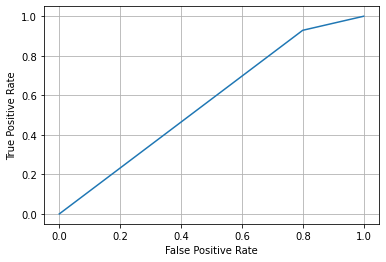

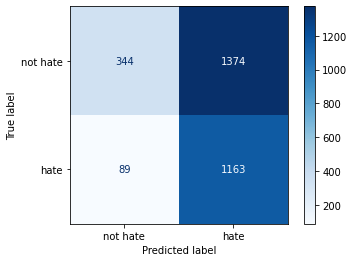

In [15]:
test_pred = trainer.predict(dataset['test']).predictions.argmax(axis=1)
test_true = dataset['test']['label']
cm = confusion_matrix(test_true, test_pred)

print('Accuracy: ', accuracy_score(test_true, test_pred))
print('Precision: ', precision_score(test_true, test_pred))
print('Recall: ', recall_score(test_true, test_pred))
print('F1: ', f1_score(test_true, test_pred))
print('ROC AUC: ', roc_auc_score(test_true, test_pred))

fpr, tpr, thresholds = roc_curve(test_true, test_pred)
roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_plot.plot()
plt.grid()
plt.show()

cm_plot = ConfusionMatrixDisplay(
    cm, display_labels=['not hate', 'hate'])
cm_plot.plot(cmap='Blues')
plt.show()


# <font color='purple'>References</font>

1.   https://huggingface.co/metrics
2.   https://huggingface.co/docs/transformers/training
